### Creating Description2Vector for Geohashes

This notebook create a description to vector representation for each geohash location R

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import pytz
import pygeohash as gh
from haversine import haversine
import time
import cPickle
import glob
import json
import re

geohash_prec = 5

In [2]:
cities = {'LosAngeles': [33.700615, 34.353627, -118.683511, -118.074559], 
           'Houston': [29.497907,30.129003,-95.797178,-94.988191],
           'Austin': [30.079327, 30.596764,-97.968881,-97.504838],
           'Dallas': [32.559567,33.083278,-97.036586,-96.428928],
           'Charlotte': [34.970168,35.423667,-81.060925,-80.622687],
           'Atlanta': [33.612410,33.916999,-84.575600,-84.231911],
           'Miami': [25.664776,25.942874,-80.386562,-80.118637]}

time_zones = {'Houston':'US/Central', 'Charlotte':'US/Eastern', 'Miami': 'US/Eastern', 'Dallas':'US/Central',
              'Atlanta':'US/Eastern', 'Austin':'US/Central', 'LosAngeles':'US/Pacific'}

start = datetime(2017, 5, 1)
finish   = datetime(2018, 5, 31)

begin = datetime.strptime('2017-05-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end   = datetime.strptime('2018-05-31 23:59:59', '%Y-%m-%d %H:%M:%S')

### 1: Load Past Traffic Events Data

In [4]:
path = 'Traffic/Data_Augmented/'
mq = pd.read_csv(path + 'MapQuest-Augmented_Refined.csv')
mq.head()

/usr/local/python/2.7-conda5.2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3,13,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Id,Source,Type,EventCode,RefinedType,Severity,StartPoint_Lat,StartPoint_Lng,EndPoint_Lat,EndPoint_Lng,...,WindChill(F),Humidity(%),Pressure(in),Visibility(mi),WindDir,WindSpeed(mph),Precipitation(in),Event,Conditions,WeatherSeverity
0,M-1,MapQuest,Construction,735,Construction,2,39.863071,-84.255028,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M-2,MapQuest,Construction,701,Construction,2,39.328114,-84.238556,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M-3,MapQuest,Construction,701,Construction,3,39.681412,-84.229820,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M-4,MapQuest,Construction,407,Construction,2,39.747940,-84.206093,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M-5,MapQuest,Construction,735,Construction,2,39.758739,-84.203438,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
mq['StartTime(UTC)'] = mq['StartTime(UTC)'].astype('datetime64[ns]', errors = 'ignore')
mq['EndTime(UTC)'] = mq['EndTime(UTC)'].astype('datetime64[ns]', errors = 'ignore')

In [6]:
for c in cities:
    crds = cities[c]
    subset_all = mq[(mq['StartTime(UTC)'] >= start) & (mq['StartTime(UTC)'] < end) & (mq['StartPoint_Lat']>crds[0]) 
                   & (mq['StartPoint_Lat']<crds[1]) & (mq['StartPoint_Lng']>crds[2]) & (mq['StartPoint_Lng']<crds[3])]
    
    subset_accidents = mq[(mq['RefinedType']=='Accident') & (mq['StartTime(UTC)'] >= start) & (mq['StartTime(UTC)'] < finish) 
                          & (mq['StartPoint_Lat']>crds[0]) & (mq['StartPoint_Lat']<crds[1]) & (mq['StartPoint_Lng']>crds[2]) 
                          & (mq['StartPoint_Lng']<crds[3])]
    
    print 'For {} we have {} incidents, with {} accidents! ratio {:.2f}'.format(c, len(subset_all), len(subset_accidents), 
                                                                               len(subset_accidents)*1.0/len(subset_all))
    
    subset_all.to_csv('temporary_for_nlp/MQ_{}_20170501_20180531.csv'.format(c), index=False)
    

For Houston we have 213897 incidents, with 27861 accidents! ratio 0.13
For LosAngeles we have 468105 incidents, with 32086 accidents! ratio 0.07
For Charlotte we have 73662 incidents, with 23468 accidents! ratio 0.32
For Miami we have 160960 incidents, with 6535 accidents! ratio 0.04
For Dallas we have 123914 incidents, with 15518 accidents! ratio 0.13
For Atlanta we have 112883 incidents, with 9221 accidents! ratio 0.08
For Austin we have 83011 incidents, with 17166 accidents! ratio 0.21


### 2: Load GloVe Word Embedding Vectors

In [3]:
word2vec = {}
with open('glove.6B.100d.txt', 'r') as reader:
    for line in reader:
        parts = line.replace('\r', '').replace('\n', '').split(' ')
        v = [float(parts[i]) for i in range(1, len(parts))]
        word2vec[parts[0]] = v
        

print 'loaded {} word vectors!'.format(len(word2vec))


loaded 400000 word vectors!


In [4]:
def return_desc2vec(input):
    parts = re.split(' - | |\.|\\\|/|;|,|&|!|\?|\(|\)|\[|\]|\{|\}', input)
    parts = [p.lower() for p in parts]
    v = []
    for p in parts:
        if len(p) ==0: continue
        if p in word2vec: v.append(word2vec[p])
#         else: 
#             v.append(word2vec['UNK'])
    if len(v) ==0: print input
    v = np.mean(v, axis=0)
    return v

#### Get Traffic Data

In [5]:
# load valid geohashes
valid_geohashes = set() # those with traffic accident data from 06/01/2018 to 08/31/2018
with open('vectors/geohash_to_poi_vec.csv', 'r') as reader:
    for line in reader:
        if 'Geohash' in line: continue
        valid_geohashes.add(line.split(',')[0])

In [9]:
geo_to_vec = {}
start_timestamp = time.time()

for c in cities:
    
    # add map-quest data
    with open('temporary_for_nlp/MQ_{}_20170501_20180531.csv'.format(c), 'r') as file:
        header = False
        for line in file:
            if not header:
                header = True
                continue
            parts = line.replace('\r', '').replace('\n', '').split(',')
                        
            start_gh = gh.encode(float(parts[6]), float(parts[7]), precision=geohash_prec)     
            if start_gh not in valid_geohashes: continue
            
            mat = []
            if start_gh in geo_to_vec: mat = geo_to_vec[start_gh]
            mat.append(return_desc2vec(parts[17]))
            geo_to_vec[start_gh] = mat
            
    
    # add bing data
    with open('temporary_for_nlp/BG_{}_20170501_20180531.csv'.format(c), 'r') as file:
        header = False
        for line in file:
            if not header:
                header = True
                continue
            parts = line.replace('\r', '').replace('\n', '').split(',')
            
            start_gh = gh.encode(float(parts[5]), float(parts[6]), precision=geohash_prec)
            if start_gh not in valid_geohashes: continue
           
            mat = []
            if start_gh in geo_to_vec: mat = geo_to_vec[start_gh]
            mat.append(return_desc2vec(parts[16]))
            geo_to_vec[start_gh] = mat
    
    print 'Done with {} in {:.1f} sec!'.format(c,time.time()-start_timestamp)
    start_timestamp = time.time()
            

Done with Houston in 31.7 sec!
Done with LosAngeles in 67.9 sec!
Done with Charlotte in 9.8 sec!
Done with Miami in 23.5 sec!
Done with Dallas in 17.7 sec!
Done with Atlanta in 17.6 sec!
Done with Austin in 10.7 sec!


## Create Textual Feature Vector for each Geohash

In [12]:
writer = open('vectors/geohash_to_text_vec.csv', 'w')
writer.write('Geohash,vec\n')

for g in geo_to_vec:
    vec = list(np.mean(geo_to_vec[g], axis=0))
    v = [str(vec[i]) for i in range(len(vec))]
    v = ' '.join(v)
    writer.write(g + ',' + v + '\n')
writer.close()

In [13]:
g2v = []
glb = []
for g in geo_to_vec:
    glb.append(g)
    vec = np.mean(geo_to_vec[g], axis=0)
    g2v.append(vec)

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [14]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(g2v)

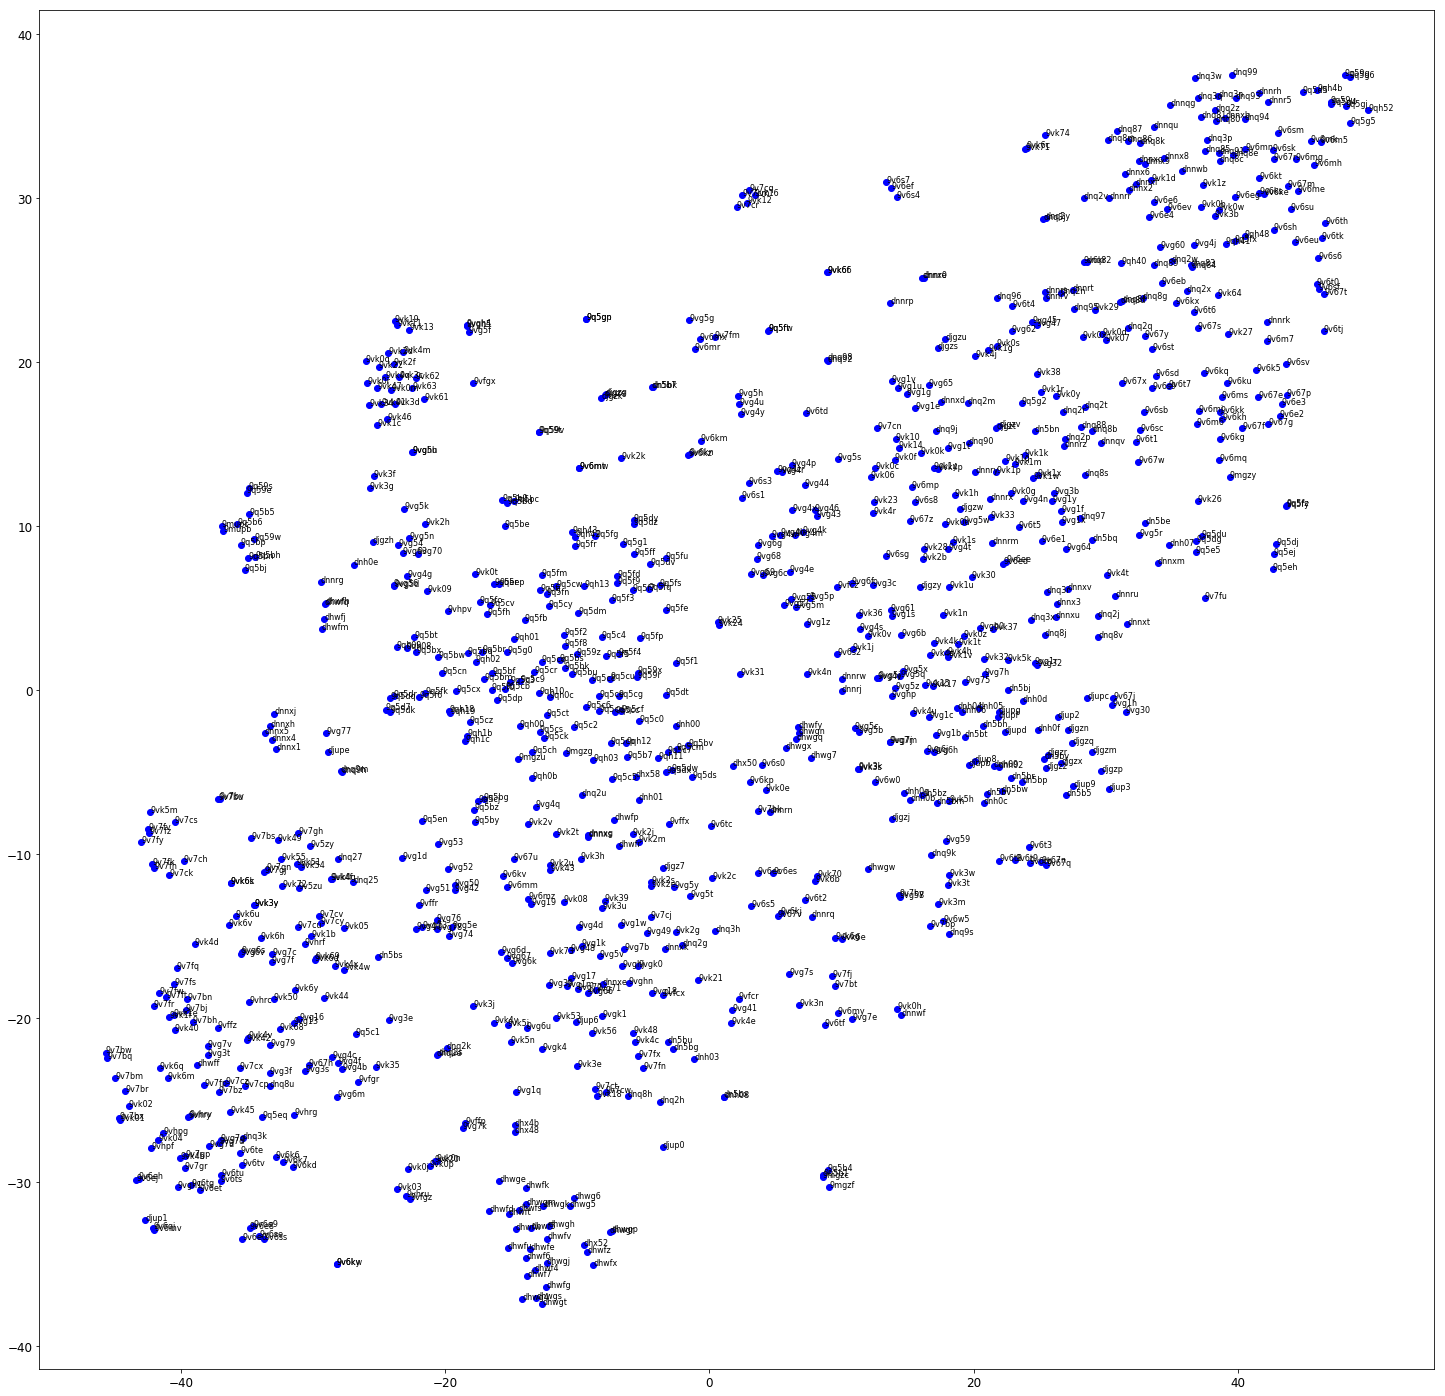

In [15]:
font= {'size': 12}
plt.rc('font', **font)
fig = plt.figure(figsize=(25,25))
ax  = fig.add_subplot(111)

for i in range(len(glb)):
    ax.scatter(X_2d[i,0], X_2d[i,1], color='blue')

for i, lb in enumerate(glb):
    ax.annotate(lb, xy=(X_2d[i, 0], X_2d[i, 1]), size=8)
plt.savefig('geo2vec.pdf')
plt.show()

In [72]:
gh.encode(34.036373, -118.245150, 5)

'9q5ct'

In [16]:
from haversine import haversine
gh.decode_exactly('9vk1k')

(29.77294921875, -95.42724609375, 0.02197265625, 0.02197265625)

In [18]:
haversine(gh.decode_exactly('9vg3t')[0:2], gh.decode_exactly('dhwff')[0:2], 'km')

1728.3560210320886